In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/Dataset/RSCCASN.csv', index_col='DATE', parse_dates=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [ ]:
dataset.describe()

,Sales
count,334.000000
mean,16325.095808
std,5369.839014
min,6938.000000
25%,12298.500000
50%,15878.500000
75%,19772.500000
max,34706.000000


In [ ]:
dataset.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


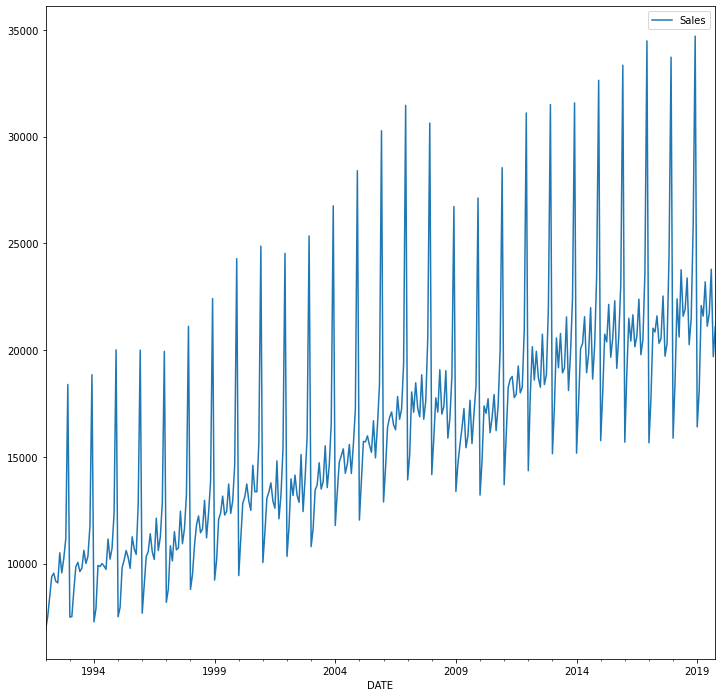

In [ ]:
dataset.columns = ['Sales']
dataset.plot(figsize=(12,12))

In [ ]:
test_sp=len(dataset)-18

In [ ]:
train = dataset.iloc[:test_sp]
test = dataset.iloc[test_sp:]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train =  scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length, batch_size=1)

In [ ]:
X,y = generator[0]

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length, batch_size=1)

In [ ]:
model.fit_generator(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
304/304 [==============================] - 2s 6ms/step - loss: 0.0247 - val_loss: 0.0104
Epoch 2/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0182 - val_loss: 0.0028
Epoch 3/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0015
Epoch 4/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0072 - val_loss: 9.0760e-04
Epoch 5/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 6/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 0.0095


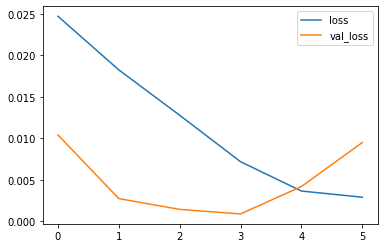

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
n_features = 1
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
prediction = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = prediction

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,23661.945908
2018-06-01,21589,22603.297680
2018-07-01,21919,22881.728687
2018-08-01,23381,24555.332263
2018-09-01,20260,22400.352713
2018-10-01,21473,23135.264191
2018-11-01,25831,26796.740117
2018-12-01,34706,35892.312791
2019-01-01,16410,19100.478044


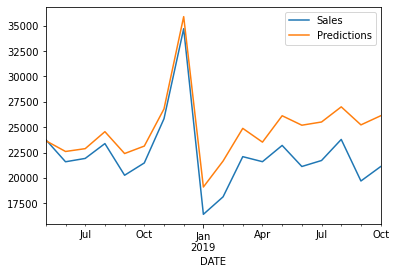

In [ ]:
test.plot()